In [25]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


def fft2(img: np.array):
    M, N = img.shape
    fourier = np.matmul(exp_mu(img), np.matmul(img, exp_nu(img)))
    return fourier


def inverse_fft2(img: np.array):
    M, N = img.shape
    inv_fourier = np.matmul(exp_mu(img, inverse=True), np.matmul(
        img, exp_nu(img, inverse=True))) / (M * N)
    return inv_fourier


def highpass(img, radius=45):
    h, w = img.shape[0], img.shape[1]
    filtered = [[0 for _ in range(w)] for _ in range(h)]
    for i in range(h):
        for j in range(w):
            distance = ((i - h // 2) ** 2 + (j - w // 2) ** 2)
            if distance < radius ** 2:
                continue
            filtered[i][j] = img[i][j]
    return np.array(filtered)


def exp_mu(img: np.array, inverse=False):
    M = img.shape[0]
    result = [[0 for _ in range(M)] for _ in range(M)]
    for u in range(M):
        for m in range(M):
            if inverse:
                result[u][m] = np.exp(2j * np.pi * m * u / M)
            else:
                result[u][m] = np.exp(-2j * np.pi * m * u / M)
    return np.array(result)


def exp_nu(img: np.array, inverse=True):
    N = img.shape[1]
    result = [[0 for _ in range(N)] for _ in range(N)]
    for v in range(N):
        for n in range(N):
            if inverse:
                result[v][n] = np.exp(2j * np.pi * n * v / N)
            else:
                result[v][n] = np.exp(-2j * np.pi * n * v / N)
    return np.array(result)


def shift(img: np.array):
    return np.fft.fftshift(img)


def fft_shift(img: np.array):
    return np.abs(shift(fft2())).round().astype(np.uint8)


def show(img: np.array):
    plt.imshow(fft_shift(img), cmap='gray')


def azimuthal_averaging(img: np.ndarray):
    h, w = img.shape
    center = (h // 2, w // 2)
    max_radius = np.sqrt(center[0] ** 2 + center[1] ** 2)
    if max_radius != int(max_radius):
        max_radius += 1
    max_radius = int(max_radius)
    cum_sum_freq = np.array([0 for _ in range(max_radius)])
    pixels = np.array([0 for _ in range(max_radius)])
    for i in range(h):
        for j in range(w):
            radius = int(np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2))
            cum_sum_freq[radius] += img[i][j]
            pixels[radius] += 1
    cum_sum_freq = cum_sum_freq / pixels
    # cum_sum_freq = cum_sum_freq[::-1]
    cum_sum_freq = cum_sum_freq / max(cum_sum_freq)  # averaging
    return cum_sum_freq


def pipeline(img, name, center=False,  suffix=""):
    h, w = img.shape
    if center:
        suffix = "_centered"
        img = img[np.ix_(range(h // 4, 3 * h // 4), range(w // 4, 3 * w // 4))]
    print(img.shape)

    fft_img = fft2(img)
    fft_shifted = np.fft.fftshift(fft_img)
    highpass_img = highpass(fft_shifted, radius=45)
    plt.imshow(np.log(np.abs(highpass_img)), cmap='gray')
    plt.savefig("./images/frequency/00{}{}.jpg".format(name, suffix))
    plt.clf()

    inv_fft_img = inverse_fft2(highpass_img)
    plt.imshow(np.abs(inv_fft_img), cmap='gray')
    plt.savefig("./images/highpassed/00{}{}.jpg".format(name, suffix))
    plt.clf()

    return np.abs(inv_fft_img)


In [33]:
path = "/Users/yooseungkim/Downloads/fake_detection/real_and_fake_face"
fake_path = path + "/training_fake/"
real_path = path + "/training_real/"

fake_imgs = []
real_imgs = [] 

for i in range(1, 951):
    fake = cv2.imread(fake_path + "fake{}.jpg".format(i), cv2.IMREAD_GRAYSCALE)
    fake = cv2.resize(fake, (256, 256))
    fake_imgs.append(fake)
for i in range(1, 1082):
    real = cv2.imread(real_path + "real{}.jpg".format(i), cv2.IMREAD_GRAYSCALE)
    real = cv2.resize(real, (256, 256))
    real_imgs.append(real)
    

In [34]:
fake_shifted = [] 
real_shifted = [] 

for fake in tqdm(fake_imgs):
    fake = np.fft.fft2(fake)
    fake = np.fft.fftshift(fake) 
    fake_log = np.log(np.abs(fake))
    fake_shifted.append(fake_log)
    
for real in tqdm(real_imgs):
    real = np.fft.fft2(real)
    real = np.fft.fftshift(real) 
    real_log = np.log(np.abs(real))
    real_shifted.append(real_log)

100%|██████████| 1081/1081 [00:01<00:00, 675.80it/s]


In [35]:
fake_azimuthal = [] 
real_azimuthal = [] 

for shifted in tqdm(fake_shifted):
    fake_azimuthal.append(azimuthal_averaging(shifted))
    
for shifted in tqdm(real_shifted):
    real_azimuthal.append(azimuthal_averaging(shifted))
    
fake_azimuthal = np.array(fake_azimuthal)
real_azimuthal = np.array(real_azimuthal)

fake_azimuthal_mean = np.mean(fake_azimuthal, axis=0)
real_azimuthal_mean = np.mean(real_azimuthal, axis=0)

100%|██████████| 1081/1081 [02:39<00:00,  6.78it/s]


In [36]:
fake_highpass = [] 
real_highpass = [] 

for i in tqdm(fake_shifted):
    fake_highpass.append(highpass(i, radius=45))
for i in tqdm(real_shifted):
    real_highpass.append(highpass(i, radius=45))

fake_inversed = [] 
real_inversed = [] 

for i in tqdm(fake_highpass):
    fake_inversed.append(np.abs(np.fft.ifft2(i)))
    
for i in tqdm(real_highpass):
    real_inversed.append(np.abs(np.fft.ifft2(i)))
    

100%|██████████| 1081/1081 [00:02<00:00, 480.05it/s]


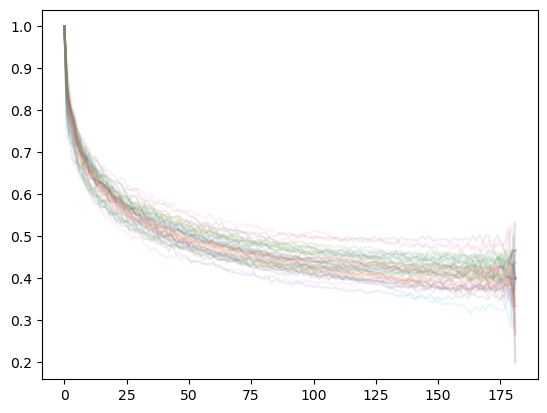

In [49]:
for i in range(50):
    plt.plot(fake_azimuthal[i], alpha=0.1)

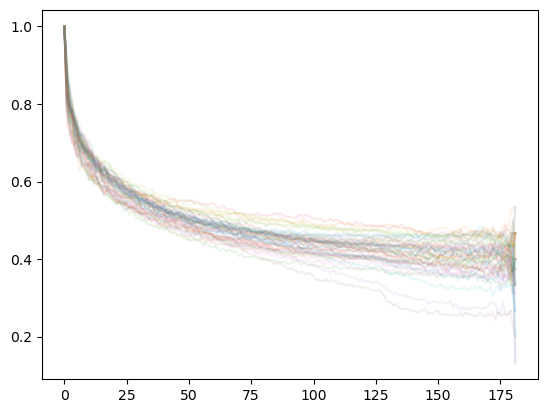

In [50]:
for i in range(50):
    plt.plot(real_azimuthal[i], alpha=0.1)